In [ ]:
#    Copyright 2020, 37.78 Tecnologia Ltda.
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        https://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

## Analyze NN model

Notebook to analyze predictions of models. 

Change **MODEL_NAME** to match your desired model.

In [1]:
MODEL_NAME = 'cnn_att' # Edit here!

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath('MIMIC_preprocessing.py'))))

In [4]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from constants import SAVE_DIR, W2V_SIZE, MAX_LENGTH, DATA_DIR

import utils
import model_functions as fun
import models
import feature_extraction as fx
import datasets


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load data and model

In [5]:
# Load dataset splits
mimic =  datasets.MIMIC_Dataset()
mimic.load_preprocessed()
mimic.split()

# Load embeddings
embedding = fx.W2V(mimic.name)
embedding.transform(mimic)


            Data Split: 47719, 1631, 3372
            

            Texts transformed!
        


In [6]:
class args:
    def __init__(self, MODEL_NAME):
        args.MODEL_NAME = MODEL_NAME

args = args(MODEL_NAME)

model = utils.get_model(args, load_path = f'{SAVE_DIR}{MODEL_NAME}')

##### Compute predictions

In [7]:
%%time 

# Predict (this will take a while)
y_pred_train = model.predict(embedding.x_train)
y_pred_val = model.predict(embedding.x_val)
y_pred_test = model.predict(embedding.x_test)

CPU times: user 1min 15s, sys: 22.7 s, total: 1min 38s
Wall time: 9min 45s


---

In [8]:
exp = fun.Experiments(y_true = [mimic.y_train, mimic.y_val, mimic.y_test],
                    y_pred = [y_pred_train, y_pred_val, y_pred_test])

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sweep through different $t$ values
- where $t$ is the threshold for prediction, i.e., only scores higher than $t$ are accounted as predicted labels

##### Compute best $t$ (in terms of F1 val)

In [9]:
ts = np.linspace(0.01,0.99, 99)

# Compute best theshold in validation subset
exp.sweep_thresholds(subset=[0,1,0], thresholds = ts)

# Compute metrics @ best threshold
exp.metrics(threshold=exp.sweep_results['best_threshold'])

Best Threshold: 0.28
--Train micro-- metrics:
F1			Precision		Recall
0.6096711199163669	0.6322105865701662	0.5886834746164911
--Val micro-- metrics:
F1			Precision		Recall
0.5438887686127348	0.5980848587451063	0.4986986633728881
--Test micro-- metrics:
F1			Precision		Recall
0.5367962443851532	0.5902698687794008	0.492206371162541


##### Plot Validation metrics at different $t$ values

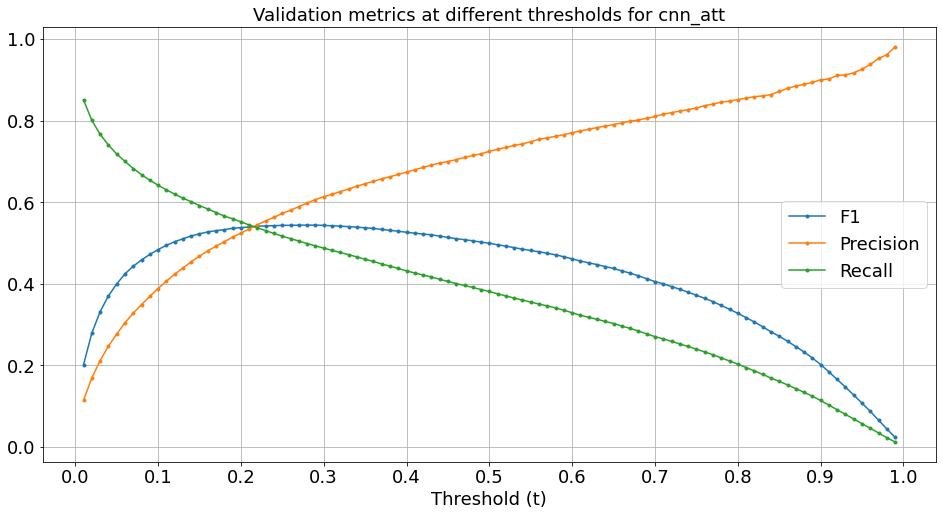

In [10]:
threshold_plot = (pd.DataFrame(exp.sweep_results)
                  .set_index('thresholds')
                  )

best_result = threshold_plot.sort_values('f1', ascending=False)['f1'].reset_index().iloc[0]

ax1 = (threshold_plot
        .drop('avg_pred',axis=1)
        .drop('best_threshold', axis=1)
        .plot(figsize=(16, 8),
        fontsize=18,
        xticks=np.linspace(0,1,11),
        style='.-'))

plt.xlabel('Threshold (t)', fontsize=18)
plt.title('Validation metrics at different thresholds for %s' %MODEL_NAME, fontsize=18)
plt.legend(['F1','Precision','Recall'], fontsize=18)
plt.grid()


plt.show()

##### Plot Validation average output list size at different $t$ values

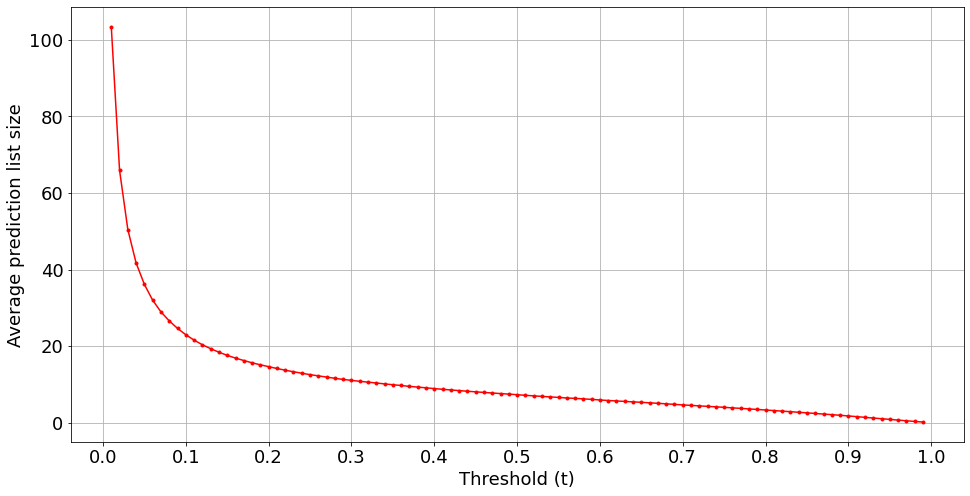

In [11]:
threshold_plot.plot(y='avg_pred', figsize=(16,8), fontsize=18, style='r.-', legend=False)
plt.xlabel('Threshold (t)',fontsize=18)
plt.ylabel('Average prediction list size',fontsize=18)
plt.xticks(np.linspace(0,1,11))
plt.grid()
plt.show()

### Sweep through different $k$ values
- where $k$ is a fixed output-size, i.e., only the $k$ highest scored labels for a sample will be predicted

##### Compute best $k$ (in terms of F1 val)

In [12]:
ks = np.linspace(1,20,20, dtype=int)

# Compute best k size in validation set
exp.sweep_k(subset=[0,1,0], ks=ks)

# Compute metrics @ best k
exp.metrics(k=exp.sweepk_results['best_k'])

Best k: 13
--Train micro-- metrics:
F1			Precision		Recall
0.5557108774909411	0.5232329647761655	0.5924875327652801
--Val micro-- metrics:
F1			Precision		Recall
0.510530634573304	0.5281799745319059	0.49402267413648593
--Test micro-- metrics:
F1			Precision		Recall
0.5038310231595374	0.530271922620677	0.4799017280178376


##### Plot Validation metrics at different $k$ values

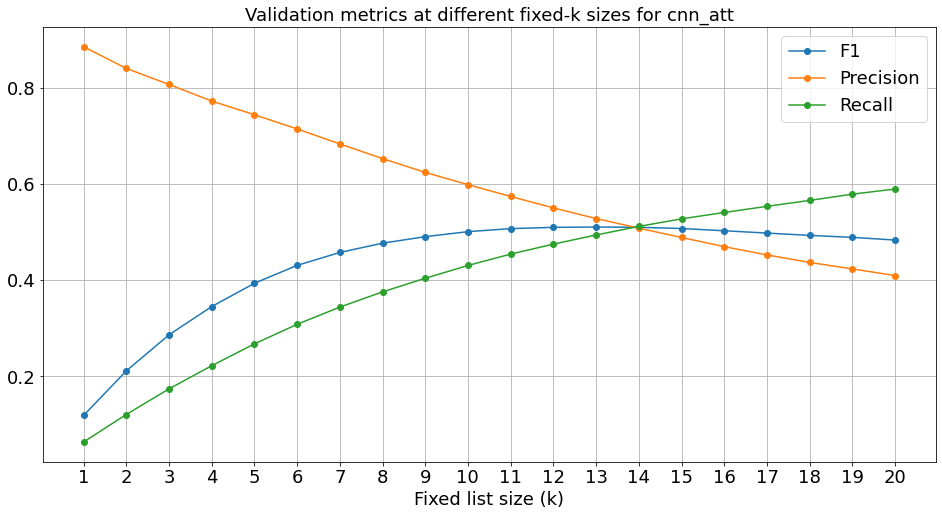

In [13]:
k_plot = (pd.DataFrame(exp.sweepk_results)
                  .set_index('ks')
                  )

ax1 = (k_plot
       .drop('best_k', axis=1)
        .plot(figsize=(16, 8),
        fontsize=18,
        style='o-'))

plt.xticks(ks)
plt.xlabel('Fixed list size (k)', fontsize=18);
plt.title('Validation metrics at different fixed-k sizes for %s' %MODEL_NAME, fontsize=18)
plt.legend(['F1','Precision','Recall'], fontsize=18);
plt.grid()

plt.show()